In [34]:
#meta 4/15/2021 myClassify (multiclass) for LSHTC - Train model with fast.ai
# task: classify text (multiclass) 
# input: data/lshtc3_wikipedia_med_df_train_tidy.pkl
#      LSHTC3 reduced ds with less labels
#      Important reset index - fast.ai dataloaders don't like a gap in index
#      to avoid -> TypeError: 'float' object is not iterable

#task: Multi-category text classification - supervise
#based on 1_classify_sentiment_spacy_multi.ipynb


#history
#      4/15/2021 TRY FAST.AI in AML
#      Accuracy ~61% 


In [35]:
%matplotlib inline
#import time as time #to track performance time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump


In [36]:
from fastai.text.all import *

In [37]:
#declare vars
SEED = 24

# LSHTC: Classify Text 
Train text classifier using Transfer Learning.  2 steps:  
1. fine-tune our language model pretrained on Wikipedia to the corpus of Expeditors survey  
2. use that model to train a classifier  



## 0. Load Data
input: a prepared pickle with pre-selected relevant fields.

In [38]:
df_tidy = load('data/lshtc3_wikipedia_med_df_train_tidy.pkl') 
print(df_tidy.shape)
print(df_tidy.columns)
print(df_tidy.dtypes)
df_tidy.head()


(151800, 2)
Index(['labels', 'text'], dtype='object')
labels    category
text        object
dtype: object


,labels,text
0,130762,"Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University."
1,352578,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran..."
2,395447,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran..."
3,27512,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran..."
4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981) was a pioneering Canadian-born American motion picture director, producer and screenwriter."


In [39]:
#clean df
df = df_tidy[['text', 'labels']].copy()
df.columns = ['text', 'label']

#reset index - dataloaders don't like a gap in index
#to fix error in next cell: TypeError: 'float' object is not iterable
#df.reset_index(drop=True, inplace=True)

df.head(2)

,text,label
0,"Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University.",130762
1,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran...",352578


## 1. Data Prep for fast.ai
Prepare our data for the language model and for the classification model separately, using fast.ai library.

### 1.1 Data Prep for Language Model Using DataBlock
fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. `DataBlock`'s handy `summary` method is useful for debugging data issues.


Putting Our Texts into Batches for a Language Model

In [40]:
#src https://docs.fast.ai/text.data.html#TextDataLoaders.from_df
#dls_lm = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, valid_col='is_valid')
dls_lm = TextDataLoaders.from_df(df, text_col='text', is_lm=True, valid_pct = 0.15, splitter=RandomSplitter(valid_pct = 0.15, seed = SEED)) 
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj william xxmaj frederick "" buffalo xxmaj bill "" xxmaj cody ( february 26 , 1846 \ u2013 xxmaj january 10 , 1917 ) was an xxmaj american soldier , bison hunter and showman . xxmaj he was born in the xxmaj iowa xxmaj territory , near xxmaj le xxmaj claire . xxmaj he was one of the most colorful figures of the xxmaj american xxmaj old xxmaj west , and","xxmaj william xxmaj frederick "" buffalo xxmaj bill "" xxmaj cody ( february 26 , 1846 \ u2013 xxmaj january 10 , 1917 ) was an xxmaj american soldier , bison hunter and showman . xxmaj he was born in the xxmaj iowa xxmaj territory , near xxmaj le xxmaj claire . xxmaj he was one of the most colorful figures of the xxmaj american xxmaj old xxmaj west , and mostly"
1,"del xxmaj ponte , the former xxmaj chief xxmaj prosecutor of the xxmaj international xxmaj criminal xxmaj tribunal for the former xxmaj yugoslavia and the xxmaj international xxmaj criminal xxmaj tribunal for xxmaj rwanda . xxmaj the book provides a retrospective account of xxmaj del xxmaj ponte 's efforts to obtain critical evidence and the arrest of persons indicted for war crimes . xxmaj xxunk has worked as a contributing editor to","xxmaj ponte , the former xxmaj chief xxmaj prosecutor of the xxmaj international xxmaj criminal xxmaj tribunal for the former xxmaj yugoslavia and the xxmaj international xxmaj criminal xxmaj tribunal for xxmaj rwanda . xxmaj the book provides a retrospective account of xxmaj del xxmaj ponte 's efforts to obtain critical evidence and the arrest of persons indicted for war crimes . xxmaj xxunk has worked as a contributing editor to xxmaj"
2,the xxmaj arts d the xxmaj western xxmaj washington xxmaj university and worked on stage in theatre productions in xxmaj seattle . xxmaj she later relocated to xxmaj los xxmaj angeles and in 1985 made her feature debut in xxmaj vision xxmaj quest . xxmaj her early television roles were on xxmaj scarecrow and xxmaj mrs xxmaj king and xxmaj my xxmaj sister xxmaj sam . xxmaj she had roles in xxmaj,xxmaj arts d the xxmaj western xxmaj washington xxmaj university and worked on stage in theatre productions in xxmaj seattle . xxmaj she later relocated to xxmaj los xxmaj angeles and in 1985 made her feature debut in xxmaj vision xxmaj quest . xxmaj her early television roles were on xxmaj scarecrow and xxmaj mrs xxmaj king and xxmaj my xxmaj sister xxmaj sam . xxmaj she had roles in xxmaj knots


In [41]:
#dataset dims
len(dls_lm.train_ds), len(dls_lm.valid_ds)

(129030, 22770)

In [42]:
#view vocab, class list
print("LM vocab size: ", len(dls_lm.vocab))
dls_lm.vocab[::100]

LM vocab size:  60008


['xxunk',
 'later',
 'william',
 '2002',
 'station',
 'service',
 'king',
 'prize',
 'metropolitan',
 'driver',
 'medical',
 'poet',
 'chris',
 'ryan',
 'girls',
 'russell',
 'going',
 'front',
 '1864',
 'industrial',
 'reviews',
 'subjects',
 'jets',
 'glass',
 'give',
 'effort',
 'syracuse',
 'rolling',
 'jobs',
 'noir',
 'prominence',
 'themselves',
 'mayer',
 'mcdonald',
 'tracy',
 '39',
 'unsuccessfully',
 'stadium',
 'ep',
 '10th',
 'stud',
 'columns',
 'ace',
 'nights',
 'progress',
 'completely',
 'benton',
 'lifelong',
 'dartmouth',
 'fairfax',
 'slavery',
 'determined',
 'alley',
 'ordinary',
 'quest',
 'agencies',
 'shipping',
 'baron',
 'stevie',
 'discussion',
 'allowing',
 'ned',
 'keeping',
 'lawn',
 'greenville',
 'carolyn',
 'tip',
 'hamburg',
 'settler',
 'veronica',
 'apparent',
 'topped',
 'deadly',
 'filipino',
 'lehman',
 'storyline',
 'relatives',
 'underwent',
 'examiner',
 'plastic',
 'dress',
 'explosion',
 'automatic',
 'residency',
 'vacant',
 'joaquin',
 'a

In [43]:
mystop

NameError: name 'mystop' is not defined

Data is ready, we can fine-tune the pretrained language model.

## 2. Model
The LM was pretrained on Wikipedia.  Fine-tune this LM to Expeditors survey corpus, and then use that as the base for our classifier.  
![ULMFiT Process](my-images/ch10_ULMFIT_process.png)
### 2.1 Fine-Tuning the Language Model


In [44]:
#class fastai.text.learner.LMLearner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [ ]:
learn.fit_one_cycle(1, 4e-2)

In [ ]:
#save and load models
learn.save('1epoch')
#learn = learn.load('1epoch')

In [45]:
learn = learn.load('1epoch')

Once the initial training has completed, continue fine-tuning the model after unfreezing

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 4e-3) 

In [ ]:
#save model encoder
learn.save_encoder('finetuned')

In [46]:
learn = learn.load_encoder('finetuned')

In [ ]:
#class fastai.text.learner.LMLearner
#learn.summary()

##### Text generation

In [47]:
TEXT = "I would recommend Baltimore because"
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

In [48]:
print("\n".join(preds))

i would recommend Baltimore because there are more things you do n't get in it . i think we need something wrong . If everybody knows you can see it , you think you can pose you . i cried you all ! !
i would recommend Baltimore because it 's not actually a city where i would have lived there . i wanted it to be like two shots like a lady . i wanted to be irresistible there . i wanted to love it twice and were


This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### 1.2 Data Prep for Classifier Model Using DataBlock
Creating the Classifier DataLoaders

In [49]:
dls_clf = TextDataLoaders.from_df(df, text_col='text', label_col='label', vocab=dls_lm.vocab, valid_pct = 0.25, splitter=RandomSplitter(0.25, seed = SEED))
dls_clf.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj richard xxmaj wright xxmaj nowels xxmaj jr . xxmaj rick xxmaj nowels is a xxmaj grammy / xxmaj ivor xxmaj novello award winning songwriter / producer who has worked with many of the most vibrant artists in contemporary music . xxmaj beginning with his number one worldwide hit single , \ xxunk xxmaj is a xxmaj place on xxmaj earth \ u201d by xxmaj belinda xxmaj carlisle in 1987 xxmaj rick has since co - written over 60 top 20 singles . xxmaj his songs have appeared on over 200 million albums . xxmaj he is a multi - instrumentalist ( guitar , keyboards , bass ) who incorporates contemporary sounds and rhythms within classic songwriting . xxmaj rick has written with or had his songs recorded by the following artists : xxmaj madonna , xxmaj dido , xxmaj john xxmaj legend / xxmaj andre 3 xxrep 3",78599
1,"xxbos xxmaj artie xxmaj wayne ( born xxmaj january 22 , 1942 ) ( born xxmaj wayne xxmaj douglas xxmaj kent ) is an xxmaj american , semi - retired record producer , award winning songwriter , and active blogger . xxmaj artie xxmaj wayne has pursued an eclectic array of vocations and xxunk , including songwriter , singer , producer , publisher , concert promoter , restaurant host , and wearable artist . xxmaj his first hit as a songwriter and producer came in 1963 : xxmaj joey xxmaj power 's "" midnight xxmaj mary "" . xxmaj he 's had over 250 covers recorded by such artists as xxmaj michael xxmaj jackson , xxmaj aretha xxmaj franklin , xxmaj tony xxmaj orlando and xxmaj dawn , xxmaj pat xxmaj boone , xxmaj helen xxmaj shapiro , xxmaj the xxmaj magic xxmaj lanterns , xxmaj joe xxmaj dassin ,",78599
2,"xxbos xxmaj claude "" buddy "" xxmaj young ( january 5 , 1926 to xxmaj october 19 , 1983 ) was an xxmaj american football player . a native of xxmaj chicago , the xxunk "" xxmaj claude "" buddy "" xxmaj young , also known as the "" bronze xxmaj bullet , "" had exceptional quickness and acceleration . xxmaj he is one of the shortest men ever to play xxup nfl football . xxmaj as a track star at the xxmaj university of xxmaj illinois , he won the xxmaj national xxmaj collegiate xxmaj championships in the 100 and 220-yard dash , tied the world record for the 45 and 60-yard dashes , and was the xxmaj amateur xxmaj athletic xxmaj union 's 100-meter champion . xxmaj buddy was xxmaj illinois state champ in the 100-yard dash , and at the xxmaj university of xxmaj illinois , he",243459


In [50]:
len(dls_clf.train_ds), len(dls_clf.valid_ds)

(113850, 37950)

### 2.2 Model Classifier

In [51]:
#class fastai.text.learner.TextLearner
learn = text_classifier_learner(dls_clf, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Prior to training the classifier, load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded

In [ ]:
learn = learn.load_encoder('finetuned')

##### Fine-tune classifier
The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference

0.043652 0.1


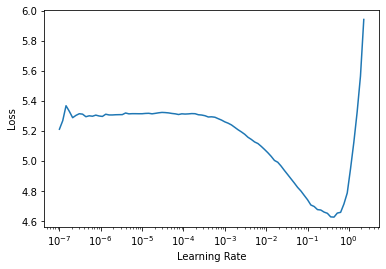

In [52]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [53]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.142723,1.739137,0.519130,15:16


In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [54]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.739295,1.523259,0.579526,19:44


Unfreeze more and train

In [55]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.525795,1.409863,0.604954,33:49


Finally, the whole model

In [56]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.537383,1.389080,0.610856,45:29
1,1.485541,1.386221,0.611831,45:30


We reached 69% accuracy. 

Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them. This is exciting stuff!

In [57]:
#learn.summary()
learn.show_results()

,text,category,category_
0,"xxbos xxmaj richard xxmaj wright xxmaj nowels xxmaj jr . xxmaj rick xxmaj nowels is a xxmaj grammy / xxmaj ivor xxmaj novello award winning songwriter / producer who has worked with many of the most vibrant artists in contemporary music . xxmaj beginning with his number one worldwide hit single , \ xxunk xxmaj is a xxmaj place on xxmaj earth \ u201d by xxmaj belinda xxmaj carlisle in 1987 xxmaj rick has since co - written over 60 top 20 singles . xxmaj his songs have appeared on over 200 million albums . xxmaj he is a multi - instrumentalist ( guitar , keyboards , bass ) who incorporates contemporary sounds and rhythms within classic songwriting . xxmaj rick has written with or had his songs recorded by the following artists : xxmaj madonna , xxmaj dido , xxmaj john xxmaj legend / xxmaj andre 3 xxrep 3",258850,78599
1,"xxbos xxmaj kim xxmaj vincent xxmaj fowley ( born xxmaj july 21 , 1939 ) is an xxmaj american record producer , impresario , songwriter and musician . xxmaj he is the son of xxmaj hollywood character actor xxmaj douglas xxmaj fowley and is also a polio survivor . xxmaj he is best known for his role behind a string of novelty , cult rock , and 45 rpm records of particular significance during the 1960s . xxmaj he is most recognized for managing the all - female punk music group titled xxmaj the xxmaj runaways in the 1970s with xxmaj joan xxmaj jett and xxmaj sandy xxmaj west \ u2014 whence also came xxmaj cherie xxmaj currie and xxmaj lita xxmaj ford . xxmaj the band was his biggest success . xxmaj he is also known for working as a producer and songwriter with xxmaj helen xxmaj reddy in",78599,167593
2,"xxbos xxmaj luther xxmaj chase xxmaj goldman ( 1909 - 2005 ) was an xxmaj american naturalist and wildlife photographer . xxmaj best known for his photographs of endangered species of birds , he was chief photographer of the xxup u.s . xxmaj fish and xxmaj wildlife xxmaj service . xxmaj luther was born in xxmaj washington , xxup d.c . , on xxmaj november 2 , 1909 . xxmaj he was fortunate in his younger years to learn nature lore from his father , xxmaj edward xxup a. xxmaj goldman , an eminent naturalist . xxmaj in teenage summer months he served as camp boy on research expeditions in xxmaj arizona , trapping and preparing specimens of mammals , his early interest , and also gaining field experience with the xxmaj predator and xxmaj xxunk xxmaj control xxmaj branch of the xxmaj bureau of xxmaj biological xxmaj survey of",221836,221836
3,"xxbos xxmaj buddy xxmaj feyne ( june 9 , 1912 - xxmaj december 10 , 1998 ) was a composer and lyricist of the swing era . xxmaj he penned the lyrics for "" tuxedo xxmaj junction "" and "" the xxmaj jersey xxmaj bounce "" - both of which were top of the xxmaj hit xxmaj parade and both are standards . xxmaj these songs and many others have been recorded by artists as diverse as xxmaj glenn xxmaj miller , xxmaj joe xxmaj williams , xxmaj the xxmaj manhattan xxmaj transfer , xxmaj ella xxmaj fitzgerald , xxmaj gene xxmaj autry , xxmaj nat xxmaj king xxmaj cole , xxmaj louis xxmaj armstrong , xxmaj the xxmaj andrews xxmaj sisters , xxmaj frankie xxmaj avalon , xxmaj joe xxmaj jackson , xxmaj george xxmaj benson and xxmaj boz xxmaj scaggs . xxmaj he was born xxmaj bernard xxmaj",258850,258850
4,"xxbos xxmaj bernard xxmaj kinsey is a xxmaj los xxmaj angeles philanthropist and entrepreneur with a passion for african - american history and art of the nineteenth and twentieth centuries . xxmaj he and his wife xxmaj shirley , one of the most admired and respected couples in xxmaj los xxmaj angeles , are famously known for espousing two life principles , \ u201cto whom much is given much is required "" and live \ u201ca life of no regrets \ u201d . xxmaj the couple have one son , xxmaj khalil . xxmaj bernard and xxmaj shirley are widely heralded for their stewardship of art , books and manuscripts that document and tell the remarkable story of xxmaj african xxmaj am

In [58]:
#save final model
learn.save('clf_final')
#export model as pkl
learn.export()

## 3. Model Evaluation
src https://docs.fast.ai/interpret.html#ClassificationInterpretation  
src code https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L51
### 3.1 Report and Confusion Matrix

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

       10088       0.76      0.91      0.83       284
       10307       0.47      0.28      0.35       116
       10590       0.35      0.20      0.26       225
       13139       0.67      0.06      0.10       141
       14661       0.49      0.20      0.28       246
       14902       0.98      0.99      0.99       265
       16954       1.00      0.95      0.97       142
       21411       0.99      0.99      0.99       141
       23214       1.00      0.98      0.99       205
       27512       0.62      0.76      0.69       136
       29931       0.38      0.65      0.48       168
       37462       0.47      0.32      0.38       135
       38982       0.24      0.49      0.32       172
       43724       0.59      0.63      0.61       243
       47471       0.83      0.96      0.89       269
       47886       0.43      0.05      0.09       234
       48448       0.95      0.97      0.96       335
       51347       1.00    

/anaconda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


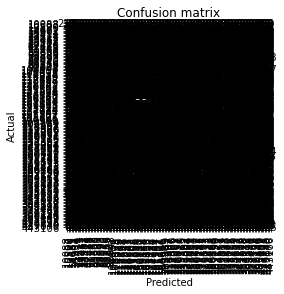

In [60]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [61]:
interp.most_confused()

[(231362, 167593, 235),
 (283823, 352578, 220),
 (308993, 93043, 215),
 (47886, 167593, 213),
 (88179, 167593, 188),
 (169463, 352578, 144),
 (14661, 347803, 141),
 (126647, 417577, 127),
 (167593, 229765, 116),
 (390846, 395447, 114),
 (283823, 284433, 113),
 (104651, 269785, 111),
 (272741, 82093, 108),
 (238882, 237392, 106),
 (260663, 269785, 105),
 (65831, 237392, 101),
 (219680, 403289, 91),
 (65566, 237392, 88),
 (427995, 352578, 87),
 (258850, 78599, 81),
 (228857, 324660, 76),
 (403289, 219680, 74),
 (187944, 167593, 69),
 (354187, 82093, 69),
 (104651, 258850, 68),
 (229765, 167593, 63),
 (167593, 88179, 61),
 (395447, 390846, 60),
 (352578, 283823, 59),
 (389174, 237392, 57),
 (395447, 352578, 57),
 (258850, 104651, 56),
 (428198, 237392, 56),
 (258850, 269785, 53),
 (269785, 104651, 53),
 (272741, 354187, 53),
 (283823, 395447, 53),
 (276713, 237392, 52),
 (304661, 347803, 52),
 (118798, 82093, 51),
 (156147, 269785, 51),
 (237392, 238882, 51),
 (344126, 237392, 51),
 (3787

In [62]:
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"xxbos xxmaj alan xxmaj ford ( december 7 , 1923 – xxmaj november 3 , 2008 ) was an xxmaj american swimmer who was a silver medalist at the 1948 xxmaj summer xxmaj olympics and was the first to swim the 100-yard freestyle in under 50 seconds .",37462,340177,0.9876576662063599,14.975310325622559
1,"xxbos xxmaj barbara xxunk is an internationally acclaimed mezzo soprano opera singer from xxmaj muskogee , xxmaj oklahoma .",93043,429649,0.9859415888786316,14.865964889526367
2,xxbos xxmaj aaron xxmaj williams is a us - american boxer .,195321,177784,0.9994522929191589,13.070860862731934
3,xxbos xxmaj christopher xxmaj robert xxmaj zorich is a former xxmaj american football defensive tackle in the xxmaj national xxmaj football xxmaj league for the xxmaj chicago xxmaj bears and xxmaj washington xxmaj redskins .,14661,304661,0.5525233149528503,13.003416061401367
4,"xxbos xxmaj ken xxmaj miles ( 1 xxmaj november 1918 in xxmaj sutton xxmaj xxunk near xxmaj birmingham , xxmaj england \ u2013 17 xxmaj august 1966 in xxmaj riverside , xxmaj california , xxmaj united xxmaj states ) was a sports car racing engineer and driver best known for his career in the xxup usa and with xxmaj american teams on the international scene .",333275,257731,0.9968680739402771,12.55294132232666
5,"xxbos xxmaj ryan xxmaj xxunk is a filmmaker and artist based in xxmaj philadelphia , xxmaj pennsylvania .",10590,135508,0.4591695964336395,12.549087524414062
6,"xxbos xxmaj edward xxmaj andrew xxmaj schultz ( born xxmaj january 27 , 1954 ) is an xxmaj american television and radio host and political pundit . xxmaj he is the host of xxmaj the xxmaj ed xxmaj show , a daily news program on xxup msnbc , and xxmaj the xxmaj ed xxmaj schultz xxmaj show , a nationally syndicated talk radio show promising "" straight talk . """,184027,286463,0.7303786277770996,12.388411521911621
7,"xxbos xxmaj william xxmaj woodruff xxmaj niles ( may 24 , 1832 - xxmaj march 31 , 1914 ) was the third bishop of the xxmaj episcopal xxmaj diocese of xxmaj new xxmaj hampshire and served as such from 1870 until his death in 1914 .",10307,269117,0.9329898953437805,12.276391983032227
8,"xxbos xxmaj james xxmaj kenneth xxmaj perry ( born xxmaj august 10 , 1960 ) is an xxmaj american professional golfer who currently plays on the xxup pga xxmaj tour and will be eligible for the xxmaj champions xxmaj tour on his 50th birthday later in 2010 .",333275,219680,0.5114709734916687,12.147027015686035
9,"xxbos xxmaj eric xxup o. xxmaj xxunk ( born xxmaj july 18 , 1975 in xxmaj irvington , xxmaj new xxmaj york ) is a former xxmaj american football defensive end in the xxmaj national xxmaj football xxmaj league for the xxmaj new xxmaj york xxmaj jets , the xxmaj cincinnati xxmaj bengals , and the xxmaj dallas xxmaj cowboys .",354187,228803,0.7313382625579834,12.11878776550293


#### 4. Predict

In [63]:
learn_inf = load_learner('models/export.pkl')
learn_inf.predict("Nice to work for Expeditors")

FileNotFoundError: [Errno 2] No such file or directory: 'models/export.pkl'

In [ ]:
mystop

## $Xtra. Data Prep for ML


In [ ]:
#interested in words in all rows, column 0
#this text_train
X = df['FINAL_COMMENT'].copy()
X.shape


In [ ]:
#for supervised learning
y = df['Q_NPS_CAT'].copy()
print(y.shape)
y.head()


In [ ]:
print(y.value_counts().sort_index())
y.value_counts().sort_index().plot(kind="bar")

In [ ]:
import fastai
from fastai import *
from fastai.text import *

#from IPython.display import display,HTML 

In [ ]:
#$was
# use TextBlock to create a language model, pass TextBlock to DataBlock
#es_lm = DataBlock(
#    blocks=TextBlock.from_df('text', seq_len=72, is_lm=True),
##    #get_x=ColReader('text'), 
#    splitter=RandomSplitter(0.2, seed = SEED)) 

#dataloaders
#dls_lm = es_lm.dataloaders(df['text'], bs=64)
#dls_lm.show_batch(max_n=2)

In [ ]:
#src https://forums.fast.ai/t/the-interpretation-of-text-classification-throws-an-error-when-used-on-a-pretrained-network/39471
def show_piece_attn(*args, **kwargs):
    from IPython.display import display, HTML
    display(HTML(piece_attn_html(*args, **kwargs)))

def _eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): _eval_dropouts(module)
            
class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`. """

In [ ]:
#https://github.com/fastai/fastai/pull/2115/files
#from fastai.train import ClassificationInterpretation

#from fastai.data.all import *
from fastai.basic_train import Learner #fastai v1 is not compatible vith v2
from fastai.vision import DatasetType


__all__ = ['TextClassificationInterpretation']

print(fastai.DatasetType.valid)

class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        _eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output + (torch.zeros_like(ids).byte(),))[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

    def html_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->str:
        text, attn = self.intrinsic_attention(text, class_id)
        return piece_attn_html(text.text.split(), to_np(attn), **kwargs)

    def show_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->None:
        text, attn = self.intrinsic_attention(text, class_id)
        show_piece_attn(text.text.split(), to_np(attn), **kwargs)

    def show_top_losses(self, k:int, max_len:int=70)->None:
        """
        Create a tabulation showing the first `k` texts in top_losses along with their prediction, actual,loss, and probability of
        actual class. `max_len` is the maximum number of tokens displayed.
        """
        from IPython.display import display, HTML
        items = []
        tl_val,tl_idx = self.top_losses()
        for i,idx in enumerate(tl_idx):
            if k <= 0: break
            k -= 1
            tx,cl = self.data.dl(self.ds_type).dataset[idx]
            cl = cl.data
            classes = self.data.classes
            txt = ' '.join(tx.text.split(' ')[:max_len]) if max_len is not None else tx.text
            tmp = [txt, f'{classes[self.pred_class[idx]]}', f'{classes[cl]}', f'{self.losses[idx]:.2f}',
                   f'{self.preds[idx][cl]:.2f}']
            items.append(tmp)
        items = np.array(items)
        names = ['Text', 'Prediction', 'Actual', 'Loss', 'Probability']
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False))) 

In [ ]:
learn.model

In [ ]:
for m in learn.model.modules():
    print('--')
    print(m)